<a href="https://colab.research.google.com/github/follboss/AAI7-Data-Camp/blob/main/Paul_graph_baseline_data_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import csv
import numpy as np
import networkx as nx

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,log_loss

In [6]:
# Create a directed graph
G = nx.read_edgelist("/content/drive/MyDrive/edgelist.txt", nodetype=int, create_using=nx.DiGraph)
print('Number of nodes:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())

Number of nodes: 166986
Number of edges: 591017


In [13]:
gcc_nodes = max(nx.connected_components(G), key=len)
gcc = G.subgraph(gcc_nodes)

print("Nodes of largest connected component", gcc.number_of_nodes())
print("Edges of largest connected component", gcc.number_of_edges())

NetworkXNotImplemented: not implemented for directed type

In [8]:
# Degree
degree_sequence = [G.degree(node) for node in G.nodes()]

print("Max degree",np.max(degree_sequence))
print("Min degree",np.min(degree_sequence))
print("Median degree",np.median(degree_sequence))
print("Mean degree",np.mean(degree_sequence))

Max degree 1491
Min degree 1
Median degree 2.0
Mean degree 7.078641323224701


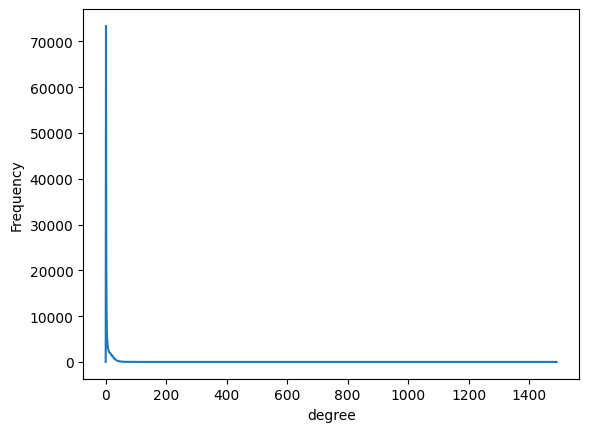

In [9]:
import matplotlib.pyplot as plt

hist = nx.degree_histogram(G)
plt.plot(hist)
plt.xlabel("degree")
plt.ylabel("Frequency")
plt.show()

In [10]:
print("Global clustering coeeficient", nx.transitivity(G))

Global clustering coeeficient 0.02490089301207304


In [11]:
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from random import randint
from sklearn.cluster import KMeans


############## Task 6
# Perform spectral clustering to partition graph G into k clusters
def spectral_clustering(G, k):

    ##################
    # your code here #
    ##################

    N = G.number_of_nodes()
    # 1) Compute Adj of G  -> A
    A = nx.adjacency_matrix(G)

    # 2) Compute Degree matrix -> D_inv
    inv_degree_sequence = [ 1/G.degree(node) for node in G.nodes()] # N number of nodes
    D_inv = diags(inv_degree_sequence)   # N x N

    # 3) Compute Laplacian -> L = I -D^-1 * A
    L = eye(N) - D_inv @ A

    # 4) Eigvectors from L using eigs
    eig_values, eig_vectors = eigs(L, k=k, which="SR")
    eig_vectors = eig_vectors.real

    # 5) Kmeans to eigs
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(eig_vectors)

    # 6) Get clusters
    clustering = {}
    for i,node in enumerate(G.nodes()):
      clustering[node] = kmeans.labels_[i]



    return clustering

In [12]:
clustering = spectral_clustering(gcc, 50)

NameError: name 'gcc' is not defined

In [ ]:
# Read training data
train_papers = list()
y_train = list()
with open("/content/drive/MyDrive/y_train.txt", "r") as f:
    for line in f:
        t = line.split(',')
        train_papers.append(int(t[0]))
        y_train.append(int(t[1][:-1]))

In [ ]:
# Read test data
test_papers = list()
with open("/content/drive/MyDrive/test.txt", "r") as f:
    for line in f:
        t = line.split(',')
        test_papers.append(int(t[0]))

In [ ]:
# Create the training matrix. Each row corresponds to a research paper.
# Use the following 3 features for each paper:
# (1) out-degree of node
# (2) in-degree of node
# (3) average degree of neighborhood of node
core_nums = nx.core_number(G.to_undirected())
X_train = np.zeros((len(train_papers), 3))
#avg_neig_deg = nx.average_neighbor_degree(G, nodes=train_papers)
for i in range(len(train_papers)):
    X_train[i,0] = G.in_degree(train_papers[i])
    X_train[i,1] = G.out_degree(train_papers[i])
    X_train[i,2] = core_nums[train_papers[i]]

In [ ]:
# Create the test matrix. Use the same 3 features as above
X_test = np.zeros((len(test_papers), 3))
#avg_neig_deg = nx.average_neighbor_degree(G, nodes=test_papers)
for i in range(len(test_papers)):
    X_test[i,0] = G.in_degree(test_papers[i])
    X_test[i,1] = G.out_degree(test_papers[i])
    X_test[i,2] = core_nums[test_papers[i]]

print("Train matrix dimension: ", X_train.shape)
print("Test matrix dimension: ", X_test.shape)

Train matrix dimension:  (35163, 3)
Test matrix dimension:  (4023, 3)


In [ ]:
# Use logistic regression to classify the research papers of the test set
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Compute accuracy and log loss
y_test = np.loadtxt('/content/drive/MyDrive/y_test_proba.txt', dtype=int, delimiter=',')
y_test = np.argmax(y_test[:,1:], axis=1)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Log loss:', log_loss(y_test, y_pred_proba))

Accuracy: 0.40939597315436244
Log loss: 1.3963189139823118
